In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns


# Downloading the data
import astropy
import astropy.table
from astropy.io import misc as misc
import h5py

# importing for the different ML models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,median_absolute_error

import xgboost as xgb

import tensorflow as tf

# To calculate the relevant parameters to regress
from provabgs import util as UT
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import flux_calib as FluxCalib


In [7]:
data = astropy.io.misc.hdf5.read_table_hdf5("/Users/linaflorez/Desktop/Astro_Techs/ML_Project/Data/fastspec_and_fastphot_provabgs_and_pca 2.hdf5")
data

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,provabgs_mcmc,provabgs_theta_bf,provabgs_z_max,provabgs_logMstar_bf,provabgs_logMstar,SCHLEGEL_COLOR,provabgs_w_zfail,provabgs_w_fibassign,is_bgs_bright,is_bgs_faint,col22,EWS,EW_IVARS,Z,pca_coeffs_fastspec,pca_coeffs_raw_masked,umap_coeffs_fastspec_2,umap_coeffs_raw_masked_2,umap_coeffs_fastspec_3,umap_coeffs_raw_masked_3,umap_coeffs_fastspec_5,umap_coeffs_raw_masked_5,ae_coeffs_fastspec_2,ae_coeffs_raw_masked_2,ae_coeffs_fastspec_3,ae_coeffs_raw_masked_3,ae_coeffs_fastspec_5,ae_coeffs_raw_masked_5,abs_sdss_u,abs_sdss_g,abs_sdss_r,abs_sdss_i,abs_sdss_z,abs_w1,abs_ivar_sdss_u,abs_ivar_sdss_g,abs_ivar_sdss_r,abs_ivar_sdss_i,abs_ivar_sdss_z,abs_ivar_w1
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,"float64[100,13]",float64[13],float64,float64,float64[100],float64,float64,float64,bool,bool,bytes16,float64[10],float64[10],float64,float64[5],float64[5],float64[2],float64[2],float64[3],float64[3],float64[5],float64[5],float64[2],float64[2],float64[3],float64[3],float64[5],float64[5],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
39627733927462346,212.07182231138097,-2.1576366940231786,0.20832115230743264,3.994752544519753e-05,1442.4746,20.47211277641004,19.429798041461506,18.743544071049342,18.77740145986165,20.33747048359048,25914,10.836395481122773 .. 0.5114743936509915,10.837870786920583 .. 0.5117299922466888,0.2141794068339524,10.586151123046875,10.583622932434082 .. 10.626855850219727,-0.08463507075054788,1.0083187937810956,2.58,True,False,provabgs_w_zfail,14.430303573608398 .. 2.6297354698181152,0.02277417480945587 .. 1.1164875030517578,0.20832115230743264,-20.055950888176866 .. -0.19519127607489473,-16.237565727370416 .. 5.334668475885828,-0.5169942378997803 .. -1.6830509901046753,0.09148402512073517 .. 2.3863604068756104,2.1690146923065186 .. 11.252616882324219,7.945523262023926 .. 7.5151448249816895,7.68181848526001 .. 9.60017204284668,1.831559419631958 .. 5.339040756225586,4.668838977813721 .. 9.629297256469727,-88.29948425292969 .. 11.992535591125488,2.766465902328491 .. 13.11249828338623,-0.6790217757225037 .. 0.9888809323310852,2.4275810718536377 .. 2.963430166244507,-2.823350429534912 .. -1.0270881652832031,-18.617569,-19.717775,-20.557684,-20.944199,-21.193878,-20.824993,8389.787,8389.787,23873.307,27395.617,27395.617,1652.7948
39627733927463809,212.14293772910978,-2.127708100431868,0.18572530109199387,5.006035401172431e-05,1223.2783,19.143279139498702,18.010202524518505,17.245911815503135,17.177611343446873,19.699680520381236,25915,11.296839857958252 .. 0.3186836729710936,11.34829262161602 .. 0.31774206145860207,0.3121052364110504,11.098465919494629,11.0506591796875 .. 11.050273895263672,-0.09139146591997549,1.0008481233258235,1.0,True,False,provabgs_w_zfail,31.741790771484375 .. 0.8731147646903992,0.004791070707142353 .. 2.114244222640991,0.18572530109199387,-41.976581555949245 .. -0.21640305905785878,-39.19635867466821 .. 1.2173006720231623,0.4993472695350647 .. 6.900646686553955,-0.8492430448532104 .. 7.256227016448975,0.6902461051940918 .. 6.680715084075928,11.506983757019043 .. 6.088058948516846,9.550555229187012 .. 5.290471076965332,-1.1921669244766235 .. 4.913886070251465,5.4477219581604 .. 31.908449172973633,-226.57408142089844 .. 30.233291625976562,6.8838019371032715 .. 24.453462600708008,-2.2115650177001953 .. 3.3037962913513184,3.7969188690185547 .. 6.471153259277344,-6.743043422698975 .. -2.1425540447235107,-19.558407,-20.717602,-21.688416,-22.12475,-22.415247,-22.177004,28842.58,28842.58,125971.04,123372.8,123372.8,15184.928
39627733927464793,212.1896378780757,-2.21605466479506,0.26623745743090205,6.674558307217808e-05,1393.6357,20.58981344892466,19.220523412254185,18.396313970957465,17.893835382724276,20.2431995499734,25915,11.15079158525007 .. 0.44309654688113753,11.199305620487813 .. 0.4412237997643244,0.29175212916152915,10.947469

## Calculating variables to regress

In [8]:
### Mass to light ratio
def mass_light_ratio():
    # M/Msun
    M_over_Msun = data["provabgs_logMstar_bf"].data
    # L/Lsun
    L_over_Lsun = 10**((data["abs_sdss_r"] - 4.65)/2.5)
    mass_to_light_ratio = 10**(M_over_Msun/L_over_Lsun)
    
    return np.log10(mass_to_light_ratio)




m_nmf = Models.NMF(burst=True, emulator=True)

#################################################################
#################################################################

### SFR averaged over the last 1Gyr
def average_sfr():
    avg_sfr = m_nmf.avgSFR(
    UT.flatten_chain(np.average(data["provabgs_mcmc"], axis = 1)[:, 0:12]), # posterior samples of the SPS parameters
    zred=0.1, # redshift of spectra
    dt=1) # Gyr
    
    return np.log10(avg_sfr)


#################################################################
#################################################################

### Mass-weighted metallicity
def mass_weighted_meta():
    Z_mw = m_nmf.Z_MW(    
    UT.flatten_chain(np.average(data["provabgs_mcmc"], axis = 1)[:, 0:12]), # posterior samples of the SPS parameters
    zred=0.1) # redshift of spectra
    
    return np.log10(Z_mw)

#################################################################
#################################################################

### Mass-weighted stellar age
def mass_weighted_age():
    tage_mw = m_nmf.tage_MW(    
    UT.flatten_chain(np.average(data["provabgs_mcmc"], axis = 1)[:, 0:12]), # posterior samples of the SPS parameters
    zred=0.1) # redshift of spectra
    
    return tage_mw

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


## Evaluating each model

In [51]:
### Evaluating models

def plot_and_stats(ydata,ypred,parameter_name, log_boolean):

    if log_boolean == True: #log case
        residuals = ypred - ydata
        mean = np.mean(residuals)
        sigma = np.std(np.abs(residuals))
        
    else: 
        residuals = np.log10(ypred) - np.log10(ydata)
        mean = np.mean(residuals)
        sigma = np.std(np.abs(residuals))
        
    naad = np.mean(np.abs(residuals - np.mean(residuals)))/.7979
    rmse = np.sqrt(np.mean((residuals)**2)) # root mean squared error
    eta = np.sum(np.abs((residuals)) > (3*sigma))/len(ydata) # percentage of outliers
    
    
    # make photo-z/spec-z plot
    plt.style.use("default")
    sns.set(font_scale = 1.5)
    
    if log_boolean == True: #log case
        a1, b1, c1 = stats.sigmaclip(ydata, 3, 3)
        a2, b2, c2 = stats.sigmaclip(ypred, 3, 3)
        
        x = np.linspace(b1-1,c1+1,50)
        outlier_upper = x + sigma*(3)
        outlier_lower = x - sigma*(3)
        mask = np.abs((residuals)) > (3*sigma)
        notmask = ~mask 
        jp = sns.jointplot(x = np.array(ydata.data), y = np.array(ypred.data), kind = "scatter",\
                 color = "limegreen", xlim=[b1-1,c1+1], ylim=[b2-1, c2+1], height=10, ratio=5, \
                       marginal_kws=dict(bins=30, fill=True))

    else: 
        a1, b1, c1 = stats.sigmaclip(np.log10(ydata), 3, 3)
        a2, b2, c2 = stats.sigmaclip(np.log10(ypred), 3, 3)
        
        x = np.linspace(b1-1,c1+1,50)
        outlier_upper = x + sigma*(3)
        outlier_lower = x - sigma*(3)
        mask = np.abs((residuals)) > (3*sigma)
        notmask = ~mask 
        jp = sns.jointplot(x = np.log10(np.array(ydata.data)), y = np.log10(np.array(ypred.data)), kind = "scatter",\
                 color = "limegreen", xlim=[(b1/1.4),(c1*1.1)], ylim=[(b2/1.4),(c2*1.1)], height=10, ratio=5, \
                       marginal_kws=dict(bins=30, fill=True))

    # draw a vertical line on the joint plot, optionally also on the x margin plot
    for ax in (jp.ax_joint, jp.ax_marg_x):
        ax.plot(x,x, color='darkgreen')
        ax.plot(x, outlier_upper, 'k--', lw = 1)
        ax.plot(x, outlier_lower, 'k--', lw = 1)

    jp.set_axis_labels('Actual Data', 'Predicted Data', fontsize=20)
    jp.ax_joint.text((c1*.9), (c2*1.1), 'XGBoost: %s\n'%parameter_name +'NAAD = %6.4f\n'%naad+'RMSE = %6.4f\n'%rmse+'outliers = %6.3f'%(eta*100)+'%', weight = "bold", fontsize=18)

    return


In [52]:
def DESI_RFR(dat_x, dat_y, parameter_name, log_bool):
    # print("DATX:", dat_x[0:10,:])
    # print("DATY:", dat_y[0:10])
    masked = np.isfinite(dat_y)
    dat_x = dat_x[masked,:]
    dat_y=dat_y[masked]
    
    # print("DATX:", dat_x.shape)
    # print("DATY:", dat_y.shape)

    
    #######################################################################################
    #### Cross-validation 
    #######################################################################################

    scaler = StandardScaler()
    scaler.fit(dat_x)
    scaled_data = scaler.transform(dat_x)

    # 20-80 test & train breakdown of data
    data_train, data_test, output_train, output_test, scaled_train, scaled_test \
                = train_test_split(dat_x, dat_y, scaled_data, test_size = 0.20, train_size = 0.80)
    
    #######################################################################################
    #### Building & Applying ML model
    #######################################################################################
    
    model_name = "Random Forest Regression"
    regrf = RandomForestRegressor(n_estimators = 200, max_depth = 10, max_features='log2')
    regrf.fit(scaled_train, output_train)
    ypredicted = regrf.predict(scaled_test)    
    ydata = output_test
    
    plot_and_stats(ydata,ypredicted,parameter_name,log_bool)

    return 

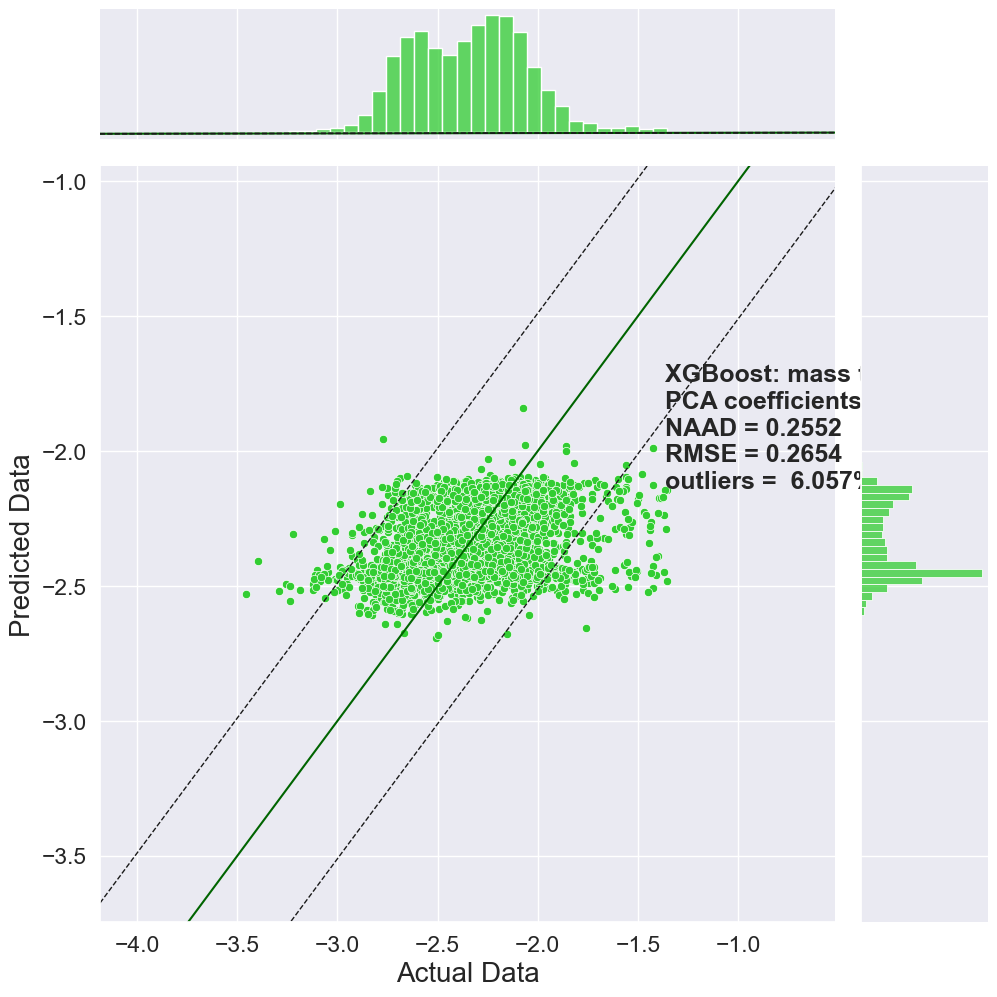

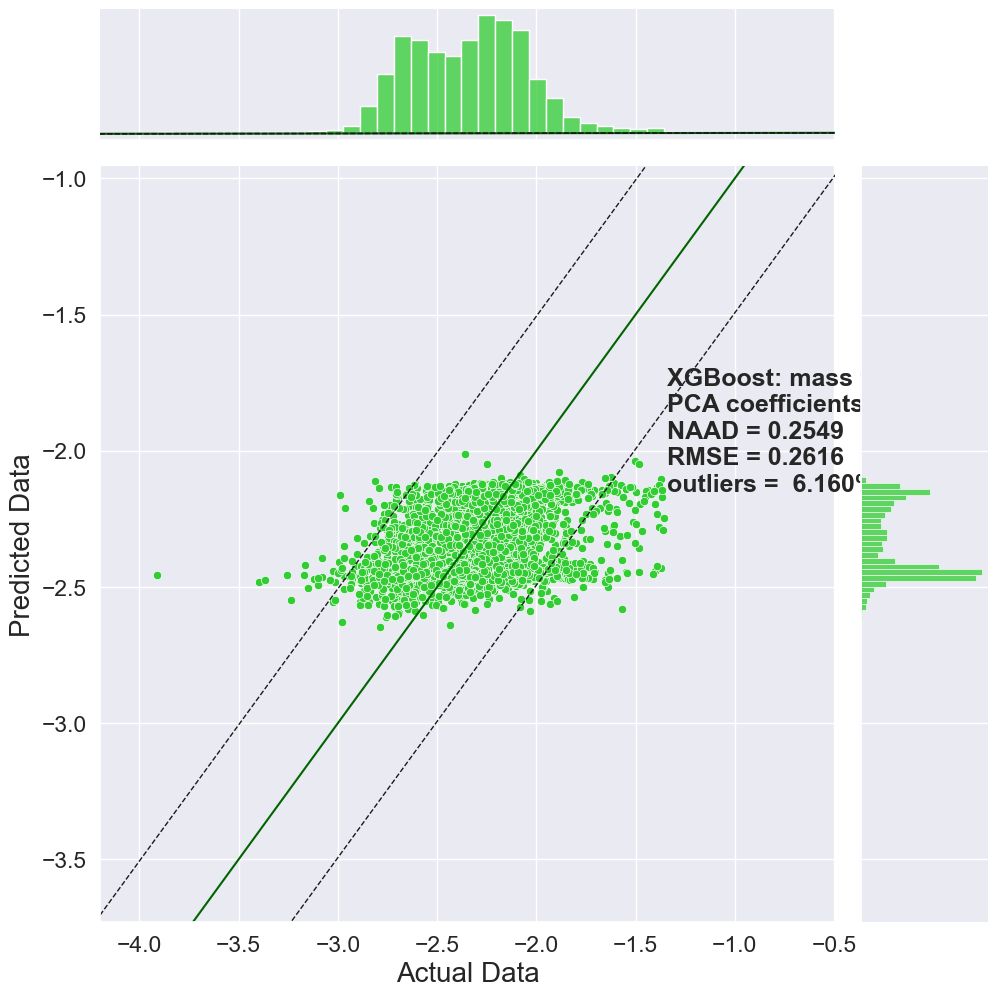

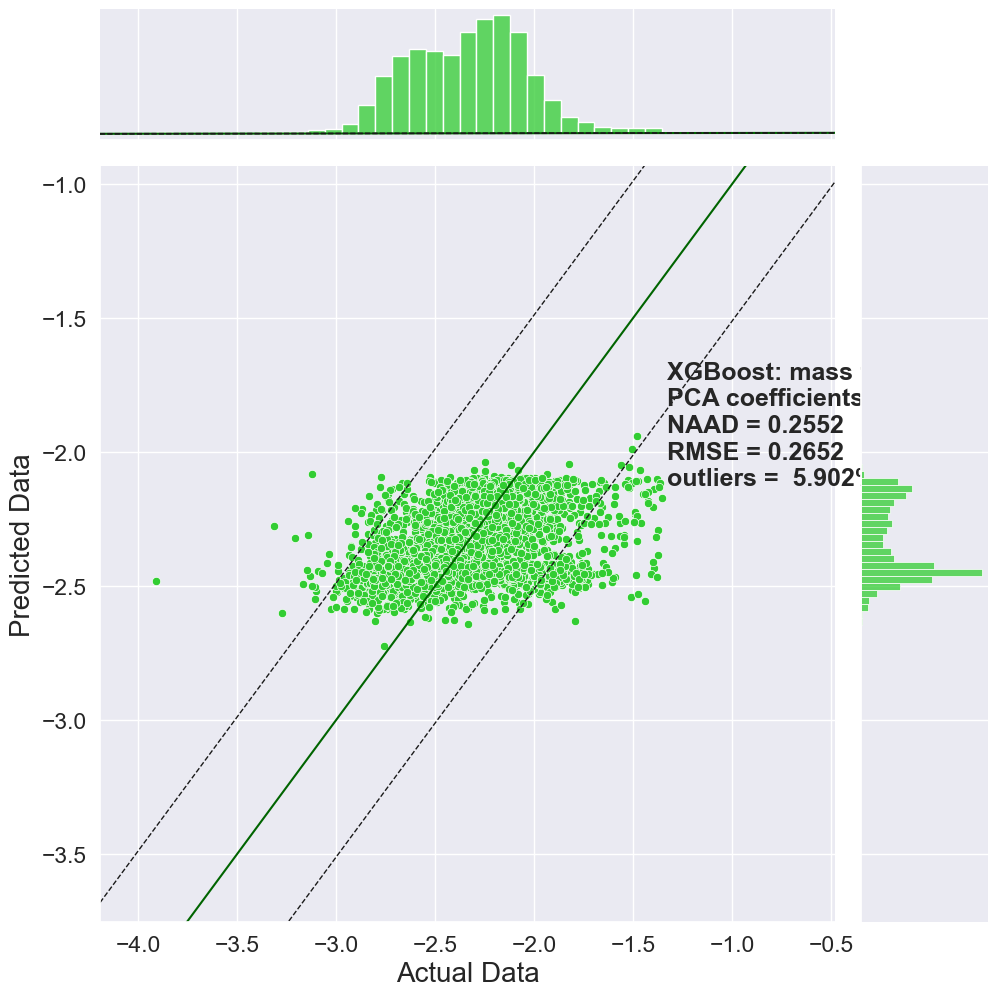

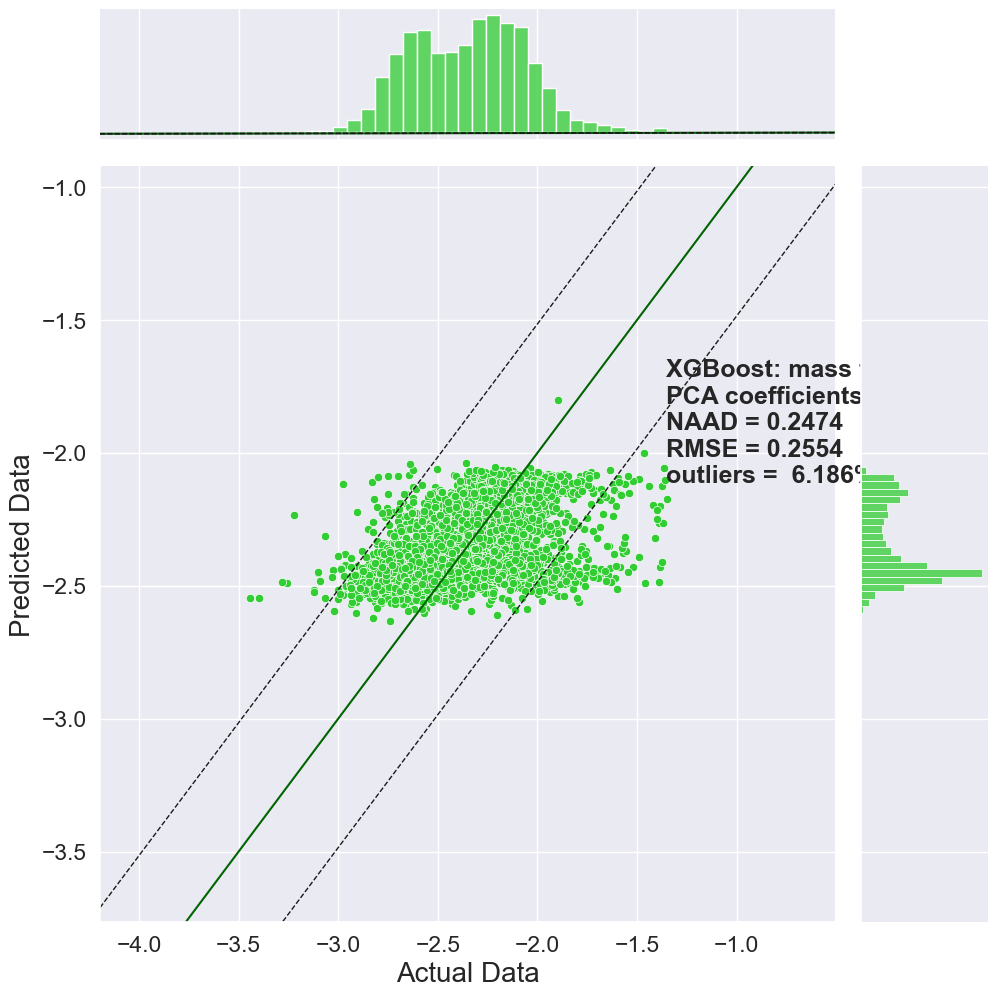

In [54]:
for i in np.arange(2,6,1):
    DESI_RFR(data["pca_coeffs_raw_masked"].data[:, 0:i], mass_weighted_meta(), "mass to age\nPCA coefficients: %i"%(i), True)

## ML Model: Random Forest Regressor
### Determining the best hyperparameters

In [ ]:
#### Finding the best ML parameters ####

# RFRegressor
dat_x, dat_y = data["pca_coeffs_raw_masked"].data, mass_light_ratio()
masked = np.isfinite(dat_y)
dat_x = dat_x[masked]
dat_y=dat_y[masked]

#######################################################################################
#### Cross-validation 
#######################################################################################

scaler = StandardScaler()
scaler.fit(dat_x)
scaled_data = scaler.transform(dat_x)

# 20-80 test & train breakdown of data
data_train, data_test, output_train, output_test, scaled_train, scaled_test \
            = train_test_split(dat_x, dat_y, scaled_data, test_size = 0.20, train_size = 0.80)

# grid search
regrf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20]
    }

grid_search = GridSearchCV(regrf, param_grid, cv=5)
grid_search.fit(scaled_train, output_train)

best_params = grid_search.best_params_

print(best_params)

In [ ]:
#### Finding the best ML parameters ####

# RFRegressor
dat_x, dat_y = data["umap_coeffs_fastspec_2"].data, mass_light_ratio()
masked = np.isfinite(dat_y)
dat_x = dat_x[masked]
dat_y=dat_y[masked]

#######################################################################################
#### Cross-validation 
#######################################################################################

scaler = StandardScaler()
scaler.fit(dat_x)
scaled_data = scaler.transform(dat_x)

# 20-80 test & train breakdown of data
data_train, data_test, output_train, output_test, scaled_train, scaled_test \
            = train_test_split(dat_x, dat_y, scaled_data, test_size = 0.20, train_size = 0.80)

# grid search
regrf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20],
    }

grid_search = GridSearchCV(regrf, param_grid, cv=5)
grid_search.fit(scaled_train, output_train)

best_params = grid_search.best_params_

print(best_params)

In [ ]:
#### Finding the best ML parameters ####

# RFRegressor
dat_x, dat_y = data["umap_coeffs_fastspec_3"].data, mass_light_ratio()
masked = np.isfinite(dat_y)
dat_x = dat_x[masked]
dat_y=dat_y[masked]

#######################################################################################
#### Cross-validation 
#######################################################################################

scaler = StandardScaler()
scaler.fit(dat_x)
scaled_data = scaler.transform(dat_x)

# 20-80 test & train breakdown of data
data_train, data_test, output_train, output_test, scaled_train, scaled_test \
            = train_test_split(dat_x, dat_y, scaled_data, test_size = 0.20, train_size = 0.80)

# grid search
regrf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20]
    }

grid_search = GridSearchCV(regrf, param_grid, cv=5)
grid_search.fit(scaled_train, output_train)

best_params = grid_search.best_params_

print(best_params)

In [ ]:
#### Finding the best ML parameters ####

# RFRegressor
dat_x, dat_y = data["umap_coeffs_fastspec_5"].data, mass_light_ratio()
masked = np.isfinite(dat_y)
dat_x = dat_x[masked]
dat_y=dat_y[masked]

#######################################################################################
#### Cross-validation 
#######################################################################################

scaler = StandardScaler()
scaler.fit(dat_x)
scaled_data = scaler.transform(dat_x)

# 20-80 test & train breakdown of data
data_train, data_test, output_train, output_test, scaled_train, scaled_test \
            = train_test_split(dat_x, dat_y, scaled_data, test_size = 0.20, train_size = 0.80)

# grid search
regrf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20]
    }

grid_search = GridSearchCV(regrf, param_grid, cv=5)
grid_search.fit(scaled_train, output_train)

best_params = grid_search.best_params_

print(best_params)

### Making the model

In [80]:
def DESI_RFR(dat_x, dat_y, parameter_name, log_bool):
    
    masked = np.isfinite(dat_y)
    dat_x = dat_x[masked]
    dat_y=dat_y[masked]
    
    #######################################################################################
    #### Cross-validation 
    #######################################################################################

    scaler = StandardScaler()
    scaler.fit(dat_x)
    scaled_data = scaler.transform(dat_x)

    # 20-80 test & train breakdown of data
    data_train, data_test, output_train, output_test, scaled_train, scaled_test \
                = train_test_split(dat_x, dat_y, scaled_data, test_size = 0.20, train_size = 0.80)
    
    #######################################################################################
    #### Building & Applying ML model
    #######################################################################################
    
    model_name = "Random Forest Regression"
    regrf = RandomForestRegressor(n_estimators = 200, max_depth = 10, max_features='log2')
    regrf.fit(scaled_train, output_train)
    ypredicted = regrf.predict(scaled_test)    
    y_data = output_test
    
    plot_and_stats(ydata,ypredicted,parameter_name,log_bool)

    return 

In [55]:
for i in np.arange(1,6,1):
    DESI_RFR(data["pca_coeffs_raw_masked"].data[:, 0:i], mass_light_ratio(), "mass to light\nPCA coefficients: %i"%(i), True)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

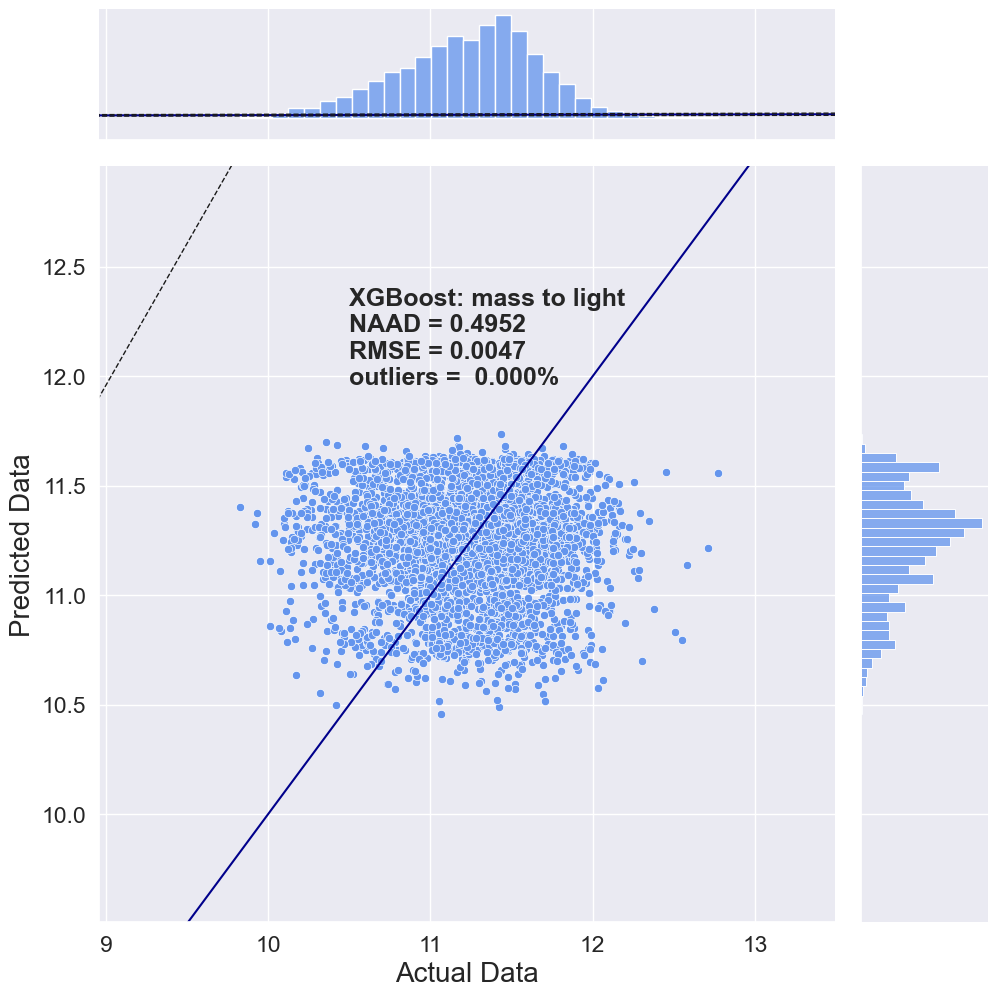

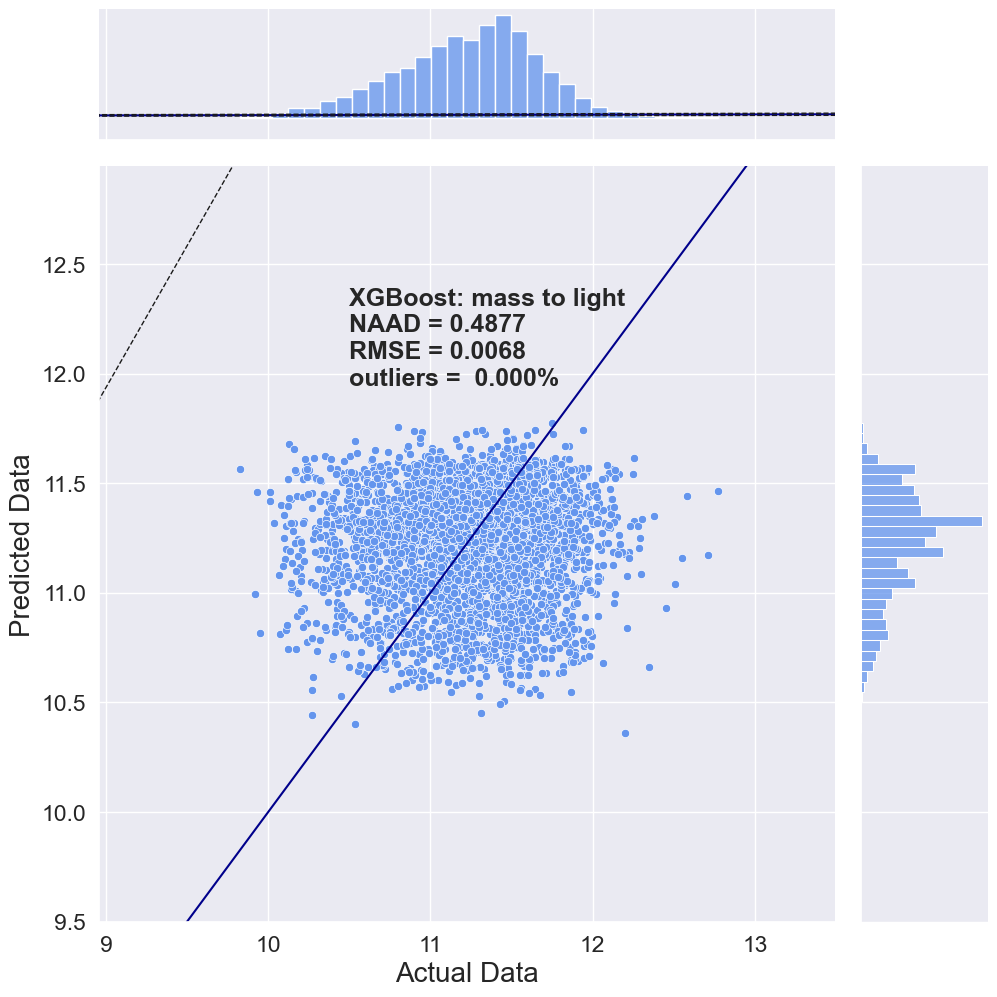

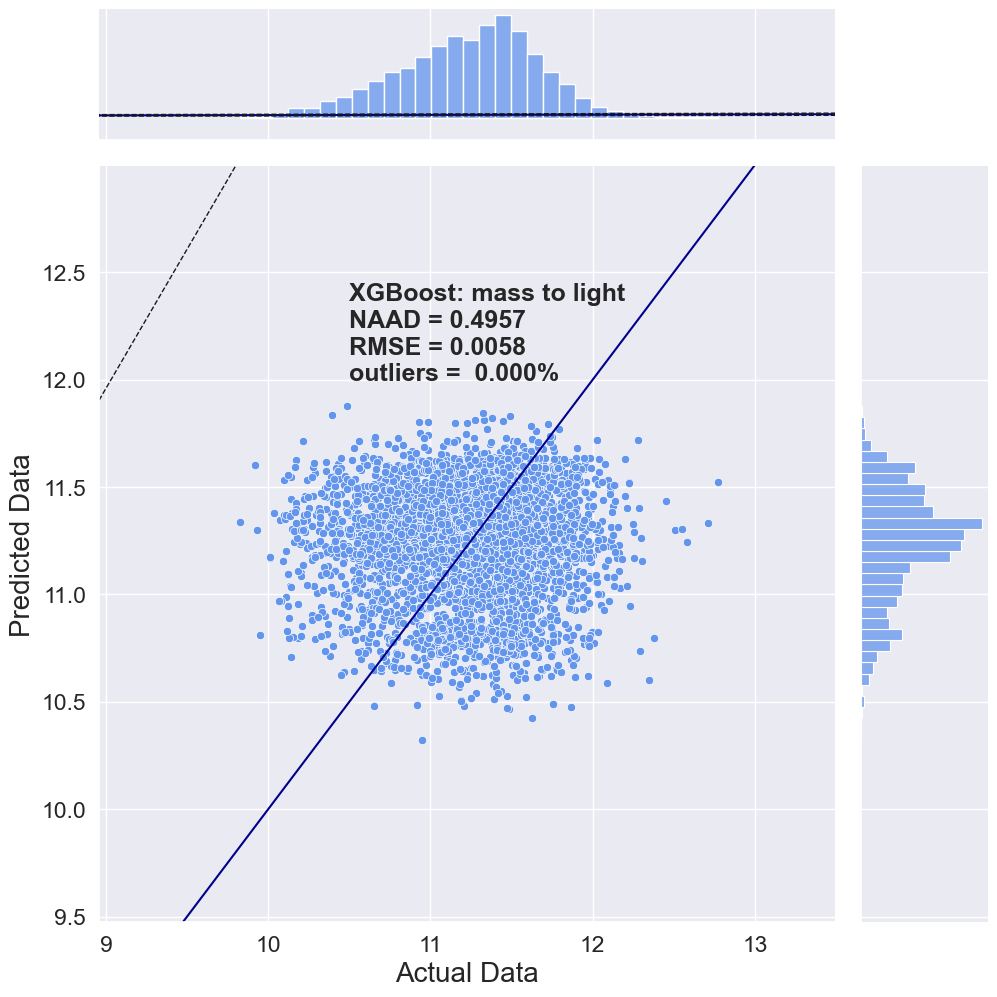

In [82]:
DESI_RFR(data["umap_coeffs_fastspec_2"].data, mass_light_ratio(), "mass to light", True)
DESI_RFR(data["umap_coeffs_fastspec_3"].data, mass_light_ratio(), "mass to light", True)
DESI_RFR(data["umap_coeffs_fastspec_5"].data, mass_light_ratio(), "mass to light", True)

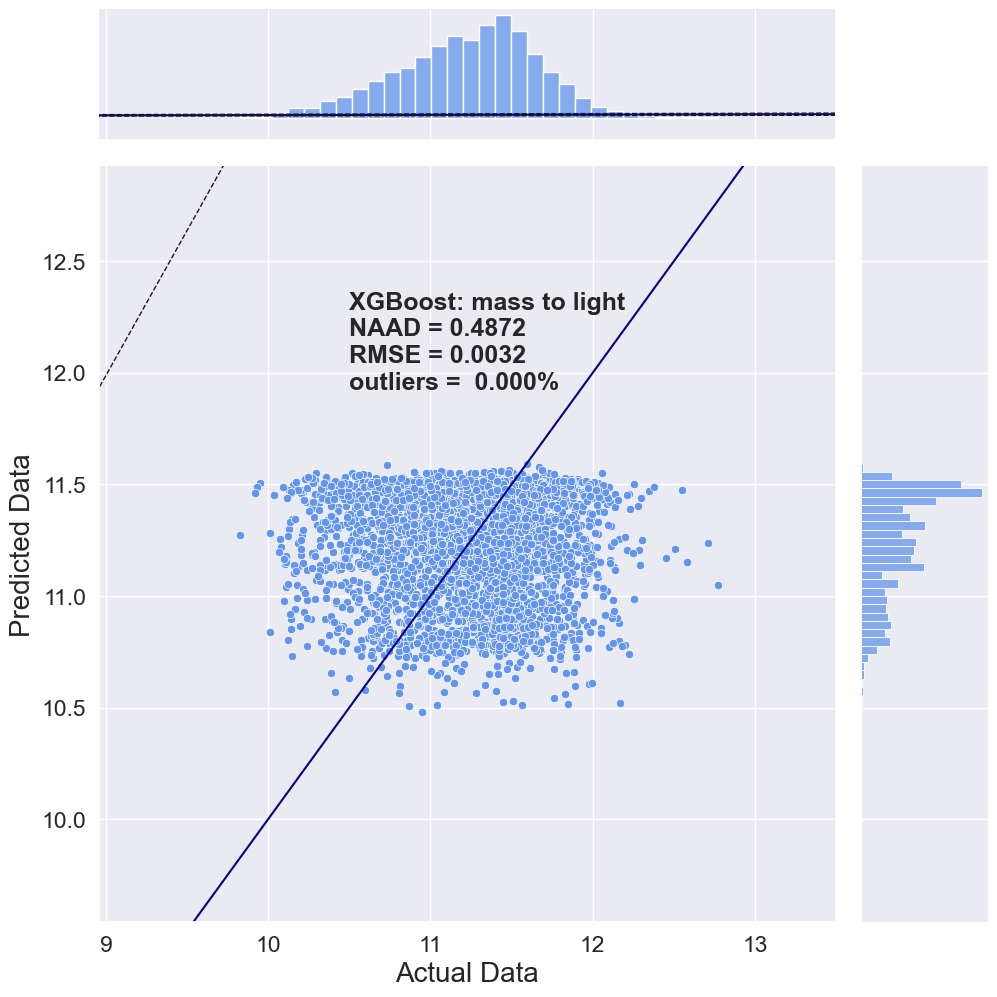

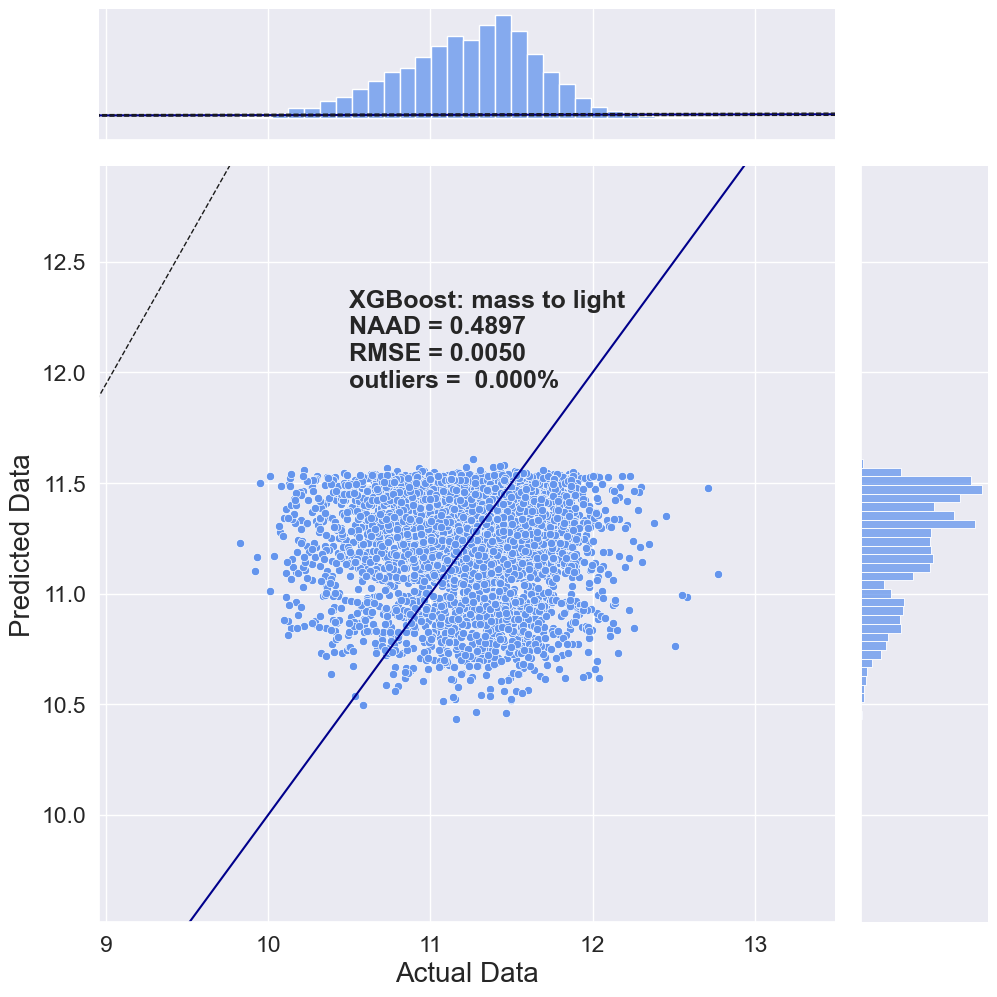

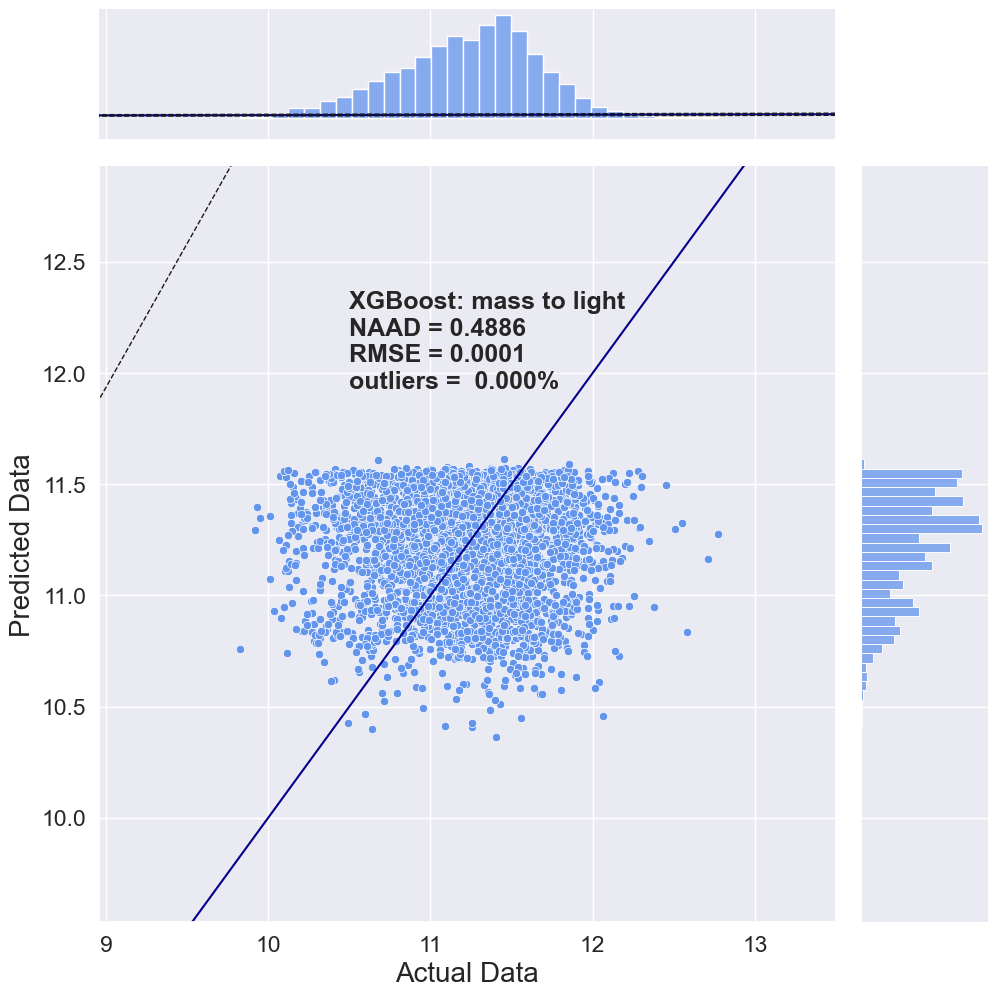

In [83]:
DESI_RFR(data["ae_coeffs_raw_masked_2"].data, mass_light_ratio(), "mass to light", True)
DESI_RFR(data["ae_coeffs_raw_masked_3"].data, mass_light_ratio(), "mass to light", True)
DESI_RFR(data["ae_coeffs_raw_masked_5"].data, mass_light_ratio(), "mass to light", True)